In [1]:
import os
import numpy as np
import glob

import torch
import torch.nn as nn

import random
from tqdm import tqdm

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed': 42,
    'early_stopping': 30,
    'scheduler': True,
    'train' : {
       'batch_size' : 2,
       'num_workers': 6,
       'epochs': 1000,
       'lr': 1e-3,
    },
    'inference' : {
       'batch_size' : 1,
       'num_workers': 6,
       'threshold': 0.35,
    },
}

In [4]:
## Fix seed
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [5]:
config['device']

device(type='cuda')

In [6]:
path = '/home/jo/Desktop/Brain_Segmentation/brain_lesion_segmentation_clean_data/'
folders= sorted(glob.glob(path+'/*'),key=lambda x: int(x.split('/')[-1].split(' ')[0][2:]))

In [7]:
# dwi_list = [x+'/after_registration_no_empty_slices_dwi.nii' for x in folders]
# mask_list = [x+'/after_registration_no_empty_slices_gt.nii' for x in folders]
# dwi_mask_list =[x+'/dwi_mask.nii' for x in folders]
# inference_list = [x+'/infer_res.npy' for x in folders]

### dataset

In [7]:
import torchio as tio
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
train_transforms = tio.Compose(
    [
        # tio.Resample(1),
        tio.Mask(masking_method='dwi_mask'),
        tio.CropOrPad((48,192,192),mask_name='dwi_mask'),
        # tio.CropOrPad((32,192,192),mask_name='dwi_mask'),
        # tio.RandomAffine(degrees=10,scales=(0.9,1.2)),
        tio.ZNormalization(masking_method='dwi_mask'),
    ]
)
valid_transforms = tio.Compose(
    [
        # tio.Resample(1),
        tio.Mask(masking_method='dwi_mask'),
        tio.CropOrPad((48,192,192),mask_name='dwi_mask'),
        # tio.CropOrPad((32,192,192),mask_name='dwi_mask'),
        tio.ZNormalization(masking_method='dwi_mask'),
    ]
)

In [10]:
fix_seed(config['seed'])
subjects = [tio.Subject(
    dwi = tio.ScalarImage(folders[i]+'/after_registration_no_empty_slices_dwi.nii'),
    adc = tio.ScalarImage(folders[i]+'/after_registration_no_empty_slices_adc.nii'),
    mask = tio.LabelMap(folders[i]+'/after_registration_no_empty_slices_gt.nii'),
    dwi_mask = tio.LabelMap(folders[i]+'/new_mask.nii'),
    res_path = folders[i]+'/infer_res.npy'
# ) for i in range(len(folders))]
) for i in range(10)]
# train_size = int(len(subjects)*0.8)
# vali_size = int(len(subjects)*0.1)
# test_size = len(folders)-train_size-vali_size
train_size = int(8)
vali_size = int(1)
test_size = 10-train_size-vali_size


train_subjects, test_subjects = train_test_split(np.array(subjects),test_size = test_size)
train_subjects,validation_subjects = train_test_split(train_subjects,test_size = vali_size)
train_dataset = tio.SubjectsDataset(train_subjects.tolist(),transform = train_transforms)
validation_dataset = tio.SubjectsDataset(validation_subjects.tolist(),transform = valid_transforms)
test_dataset = tio.SubjectsDataset(test_subjects.tolist(),transform = valid_transforms)
print(f'total data: {len(subjects)} \ntrain_size: {len(train_dataset)}, vali_size: {len(validation_dataset)}, test_size: {len(test_dataset)}')

total data: 10 
train_size: 8, vali_size: 1, test_size: 1


In [12]:
train_loader = DataLoader(dataset=train_dataset,batch_size=config['train']['batch_size'],shuffle=True,num_workers=config['train']['num_workers'])
valid_loader = DataLoader(dataset=validation_dataset,batch_size=config['train']['batch_size'],shuffle=True,num_workers=config['train']['num_workers'])
test_loader = DataLoader(dataset=test_dataset,batch_size=config['inference']['batch_size'],shuffle=True,num_workers=config['inference']['num_workers'])

### model

In [13]:
from transunet_3d import transUnet_3d
model = transUnet_3d(in_channels=2).to(config['device'])
model = nn.DataParallel(model, device_ids=[0,1])

In [11]:
# from monai.networks.nets import SwinUNETR

In [12]:
# model = SwinUNETR(img_size=(32,192,192),in_channels=1,out_channels=1).to(config['device'])
# model = nn.DataParallel(model, device_ids=[0,1])

In [14]:
# from monai.networks.nets import UNETR

In [38]:
# model = UNETR(in_channels=1,out_channels=1,img_size = (64,192,192),feature_size=32,norm_name='batch').to(config['device'])
# model = nn.DataParallel(model, device_ids=[0,1])

In [14]:
# from torchsummary import summary
# summary(model,(1,48,192,192),2)

AttributeError: Caught AttributeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1538, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/home/jo/PycharmProjects/pythonProject/brain_lesion/transunet_3d.py", line 59, in forward
    res,_ = self.vit(res)
  File "/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1547, in _call_impl
    hook_result = hook(self, args, result)
  File "/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torchsummary/torchsummary.py", line 22, in hook
    summary[m_key]["output_shape"] = [
  File "/home/jo/anaconda3/envs/build/lib/python3.8/site-packages/torchsummary/torchsummary.py", line 23, in <listcomp>
    [-1] + list(o.size())[1:] for o in output
AttributeError: 'list' object has no attribute 'size'


### train/vali

In [14]:
from monai.losses import FocalLoss, DiceLoss,DiceFocalLoss
from monai.metrics import MeanIoU

In [15]:
criterion_iou = MeanIoU(ignore_empty=True)
criterion_focal = FocalLoss()#loss
criterion_ce = nn.BCEWithLogitsLoss()#loss
criterion_dice = DiceLoss()
criterion_dice_focal = DiceFocalLoss()

### train/validation

In [14]:
def validation(config, model, valid_loader):
    fix_seed(config['seed'])
    model.eval()
    epoch_focal = 0
    epoch_ce=0
    epoch_dice=0
    epoch_iou=0
    epoch_dice_focal =0
    with torch.no_grad():
        for patches_batch in tqdm(valid_loader):
            dwi = patches_batch['dwi'][tio.DATA].type(torch.float32).to(config['device'])
            adc = patches_batch['adc'][tio.DATA].type(torch.float32).to(config['device'])
            masks = patches_batch['mask'][tio.DATA].type(torch.float32).to(config['device'])
            images = torch.cat([dwi,adc],dim=1)
            outputs = model(images)
            # outputs = torch.sigmoid(outputs)
            loss_focal = criterion_focal(outputs,masks)
            loss_ce = criterion_ce(outputs,masks)
            loss_dice = criterion_dice(outputs,masks)
            loss_focal_dice = criterion_dice_focal(outputs,masks)
            criterion_iou(outputs,masks)
            loss_iou= criterion_iou.aggregate()

            epoch_dice_focal+=loss_focal_dice.item()
            epoch_iou += loss_iou[0]
            epoch_dice+=loss_dice.item()
            epoch_ce +=loss_ce.item()
            epoch_focal+=loss_focal.item()
        length = len(valid_loader)

        res_iou = epoch_iou/length
        res_focal = epoch_focal/length
        res_ce = epoch_ce/length
        res_dice = epoch_dice/length
        res_dice_focal = epoch_dice_focal/length
        print(f'Validation_losses\nCE: {res_ce:6f}, Focal_Dice: {res_dice_focal:6f}, Focal: {res_focal:6f}, Dice: {res_dice:6f}, mIoU: {res_iou:6f}')
        valid_stat.append([res_ce,res_dice,res_focal])
    return res_focal

In [20]:
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [19]:
def training(config, model, train_loader, valid_loader):
    fix_seed(config['seed'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    length = len(train_loader)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-8, verbose=True)
    # scheduler = CosineAnnealingWarmupRestarts(optimizer,
    #                                   first_cycle_steps=20,
    #                                   cycle_mult=1.0,
    #                                   max_lr=1e-3,
    #                                   min_lr=1e-8,
    #                                   warmup_steps=5,
    #                                   gamma=1.0)
    # training loop
    for epoch in range(config['train']['epochs']):
        model.train()
        epoch_focal = 0
        epoch_ce=0
        epoch_dice=0
        epoch_iou=0
        epoch_dice_focal=0
        for patches_batch in tqdm(train_loader):
            dwi = patches_batch['dwi'][tio.DATA].type(torch.float32).to(config['device'])
            adc = patches_batch['adc'][tio.DATA].type(torch.float32).to(config['device'])
            masks = patches_batch['mask'][tio.DATA].type(torch.float32).to(config['device'])
            images = torch.cat([dwi,adc],dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            # outputs = torch.sigmoid(outputs)
            # print(outputs.shape, outputs.dtype, masks.shape, masks.dtype)
            loss_seesaw = criterion_seesaw(outputs,masks)
            print(loss_seesaw)
            loss_focal = criterion_focal(outputs,masks)
            loss_ce = criterion_ce(outputs,masks)
            loss_dice = criterion_dice(outputs,masks)
            loss_dice_focal=criterion_dice_focal(outputs,masks)
            criterion_iou(outputs,masks)
            loss_iou= criterion_iou.aggregate()


            loss = loss_focal
            loss.backward()
            optimizer.step()
            epoch_iou += loss_iou[0]
            epoch_dice_focal+=loss_dice_focal.item()
            epoch_dice+=loss_dice.item()
            epoch_ce +=loss_ce.item()
            epoch_focal+=loss_focal.item()

        res_iou = epoch_iou/length
        res_focal = epoch_focal/length
        res_ce = epoch_ce/length
        res_dice = epoch_dice/length
        res_dice_focal = epoch_dice_focal/length
        train_stat.append([res_ce,res_dice,res_focal])

        val_loss= validation(config, model, valid_loader)
        es_count += 1

        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            best_epoch = epoch + 1
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")
            torch.save(model.state_dict(),f'/home/jo/Desktop/Brain_Segmentation/weights/{epoch+1}.pt')
        if config['scheduler']:
            scheduler.step(val_loss)
        print(f'Epoch {epoch+1} Train_losses\nCE: {res_ce:6f}, Focal_Dice: {res_dice_focal:6f}, Focal: {res_focal:6f}, Dice: {res_dice:6f}, mIoU: {res_iou:6f}, Early stopping: {es_count}')
        if es_count == config['early_stopping']:
            # print(f'Epoch {epoch+1}, Train Loss: {res:6f}, ES Count: {es_count}\n')
            print(f"EARLY STOPPING COUNT에 도달했습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model
        print("------------------------------------------------------------------------------------")
    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [ ]:
# model = SwinUNETR(img_size=(32,192,192),in_channels=1,out_channels=1).to(config['device'])
# model = nn.DataParallel(model, device_ids=[0,1])
# model.load_state_dict(torch.load('/home/jo/Desktop/Brain_Segmentation/pretrained/monai_unetr.pt'))

In [20]:
train_stat, valid_stat=[],[]
best_model = training(config, model, train_loader, valid_loader)

  0%|          | 0/4 [00:08<?, ?it/s]


RuntimeError: The size of tensor a (192) must match the size of tensor b (48) at non-singleton dimension 3

In [17]:
train_stat = np.array(train_stat)
train_stat = train_stat.reshape(train_stat.shape[1],train_stat.shape[0])
valid_stat = np.array(valid_stat)
valid_stat = valid_stat.reshape(valid_stat.shape[1],valid_stat.shape[0])

In [18]:
train_df = pd.DataFrame({'Focal': train_stat[2,:], 'CE':train_stat[0,:],'Dice':train_stat[1,:]})
train_df.to_csv('/home/jo/Desktop/Brain_Segmentation/logs/transunetViT_mask_adc_znorm_train.csv')
train_df = pd.DataFrame({'Focal': train_stat[2,:], 'CE':train_stat[0,:],'Dice':train_stat[1,:]})
train_df.to_csv('/home/jo/Desktop/Brain_Segmentation/logs/transunetViT_mask_adc_znorm_valid.csv')

### test

In [34]:
# from monai.networks.nets import BasicUnet
# model = BasicUnet(spatial_dims=3, in_channels=1, out_channels=1).to(config['device'])
# model = nn.DataParallel(model, device_ids=[0,1])
# model.load_state_dict(torch.load('/home/jo/Desktop/Brain_Segmentation/pretrained/monai_basic_unet.pt'))

BasicUNet features: (32, 32, 64, 128, 256, 32).


<All keys matched successfully>

In [47]:
from transunet_3d import transUnet_3d
model = transUnet_3d(in_channels=1).to(config['device'])
model = nn.DataParallel(model, device_ids=[0,1])
model.load_state_dict(torch.load('/home/jo/Desktop/Brain_Segmentation/pretrained/transUnetViT_mask.pt'))

<All keys matched successfully>

In [30]:
def inference(config, model, test_loader):
    fix_seed(config['seed'])
    model.eval()
    epoch_focal = 0
    epoch_ce=0
    epoch_dice=0
    with torch.no_grad():
        for patches_batch in tqdm(test_loader):
            # # for one channel
            # images = patches_batch['dwi'][tio.DATA].to(config['device'])
            # masks = patches_batch['mask'][tio.DATA].float().to(config['device'])

            # for two channels
            dwi = patches_batch['dwi'][tio.DATA].type(torch.float32).to(config['device'])
            adc = patches_batch['adc'][tio.DATA].type(torch.float32).to(config['device'])
            masks = patches_batch['mask'][tio.DATA].type(torch.float32).to(config['device'])
            images = torch.cat([dwi,adc],dim=1)

            ## same
            save_path = patches_batch['res_path']
            outputs = model(images)

            outputs = torch.sigmoid(outputs).cpu().numpy()
            outputs = np.squeeze(outputs, axis=1)

            # outputs = (outputs > config['inference']['threshold']).astype(np.uint8)
            outputs = (outputs > 0.55).astype(np.uint8)

            np.save(save_path[0],outputs.squeeze(0))
            outputs = torch.from_numpy(outputs).float().to(config['device'])
            loss_focal = criterion_focal(outputs,masks.squeeze(1))
            loss_ce = criterion_ce(outputs,masks.squeeze(1))
            loss_dice = criterion_dice(outputs,masks.squeeze(1))

            epoch_dice+=loss_dice.item()
            epoch_ce +=loss_ce.item()
            epoch_focal+=loss_focal.item()
        length = len(test_loader)
        res_focal = epoch_focal/length
        res_ce = epoch_ce/length
        res_dice = epoch_dice/length

        print(f'Test Result\nCE: {1-res_ce:6f}, Focal: {1-res_focal:6f}, Dice: {1-res_dice:6f}')

In [31]:
inference(config, best_model,test_loader)

100%|██████████| 66/66 [00:14<00:00,  4.45it/s]

Test Result
CE: 0.307142, Focal: 0.826664, Dice: 0.794491


## Viewer

<Axes: >

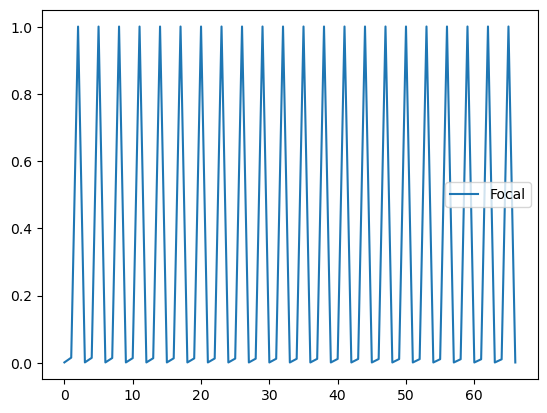

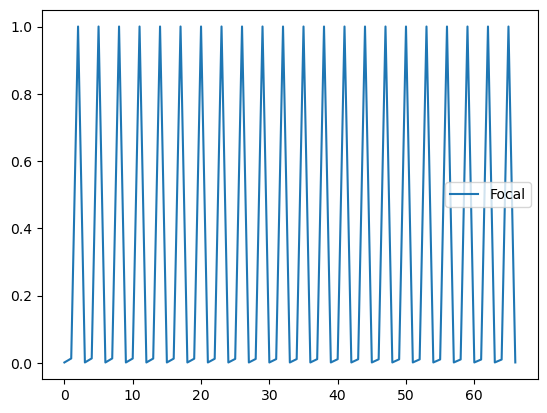

In [24]:
train_losses = pd.DataFrame(train_stat[2],columns=['Focal'])
valid_losses = pd.DataFrame(valid_stat[2], columns=['Focal'])
# print(train_stat)
train_losses.plot.line()
valid_losses.plot.line()

In [37]:
import matplotlib.pyplot as plt

In [39]:
dwi_img_list = [x+'/after_registration_no_empty_slices_dwi.npy' for x in folders]
mask_img_list = [x+'/after_registration_no_empty_slices_gt.npy' for x in folders]
inference_list = [x+'/infer_res.npy' for x in folders]

/home/jo/Desktop/Brain_Segmentation/brain_lesion_segmentation_clean_data/BP976 20190213/infer_res.npy
/home/jo/Desktop/Brain_Segmentation/brain_lesion_segmentation_clean_data/BP976 20190213/


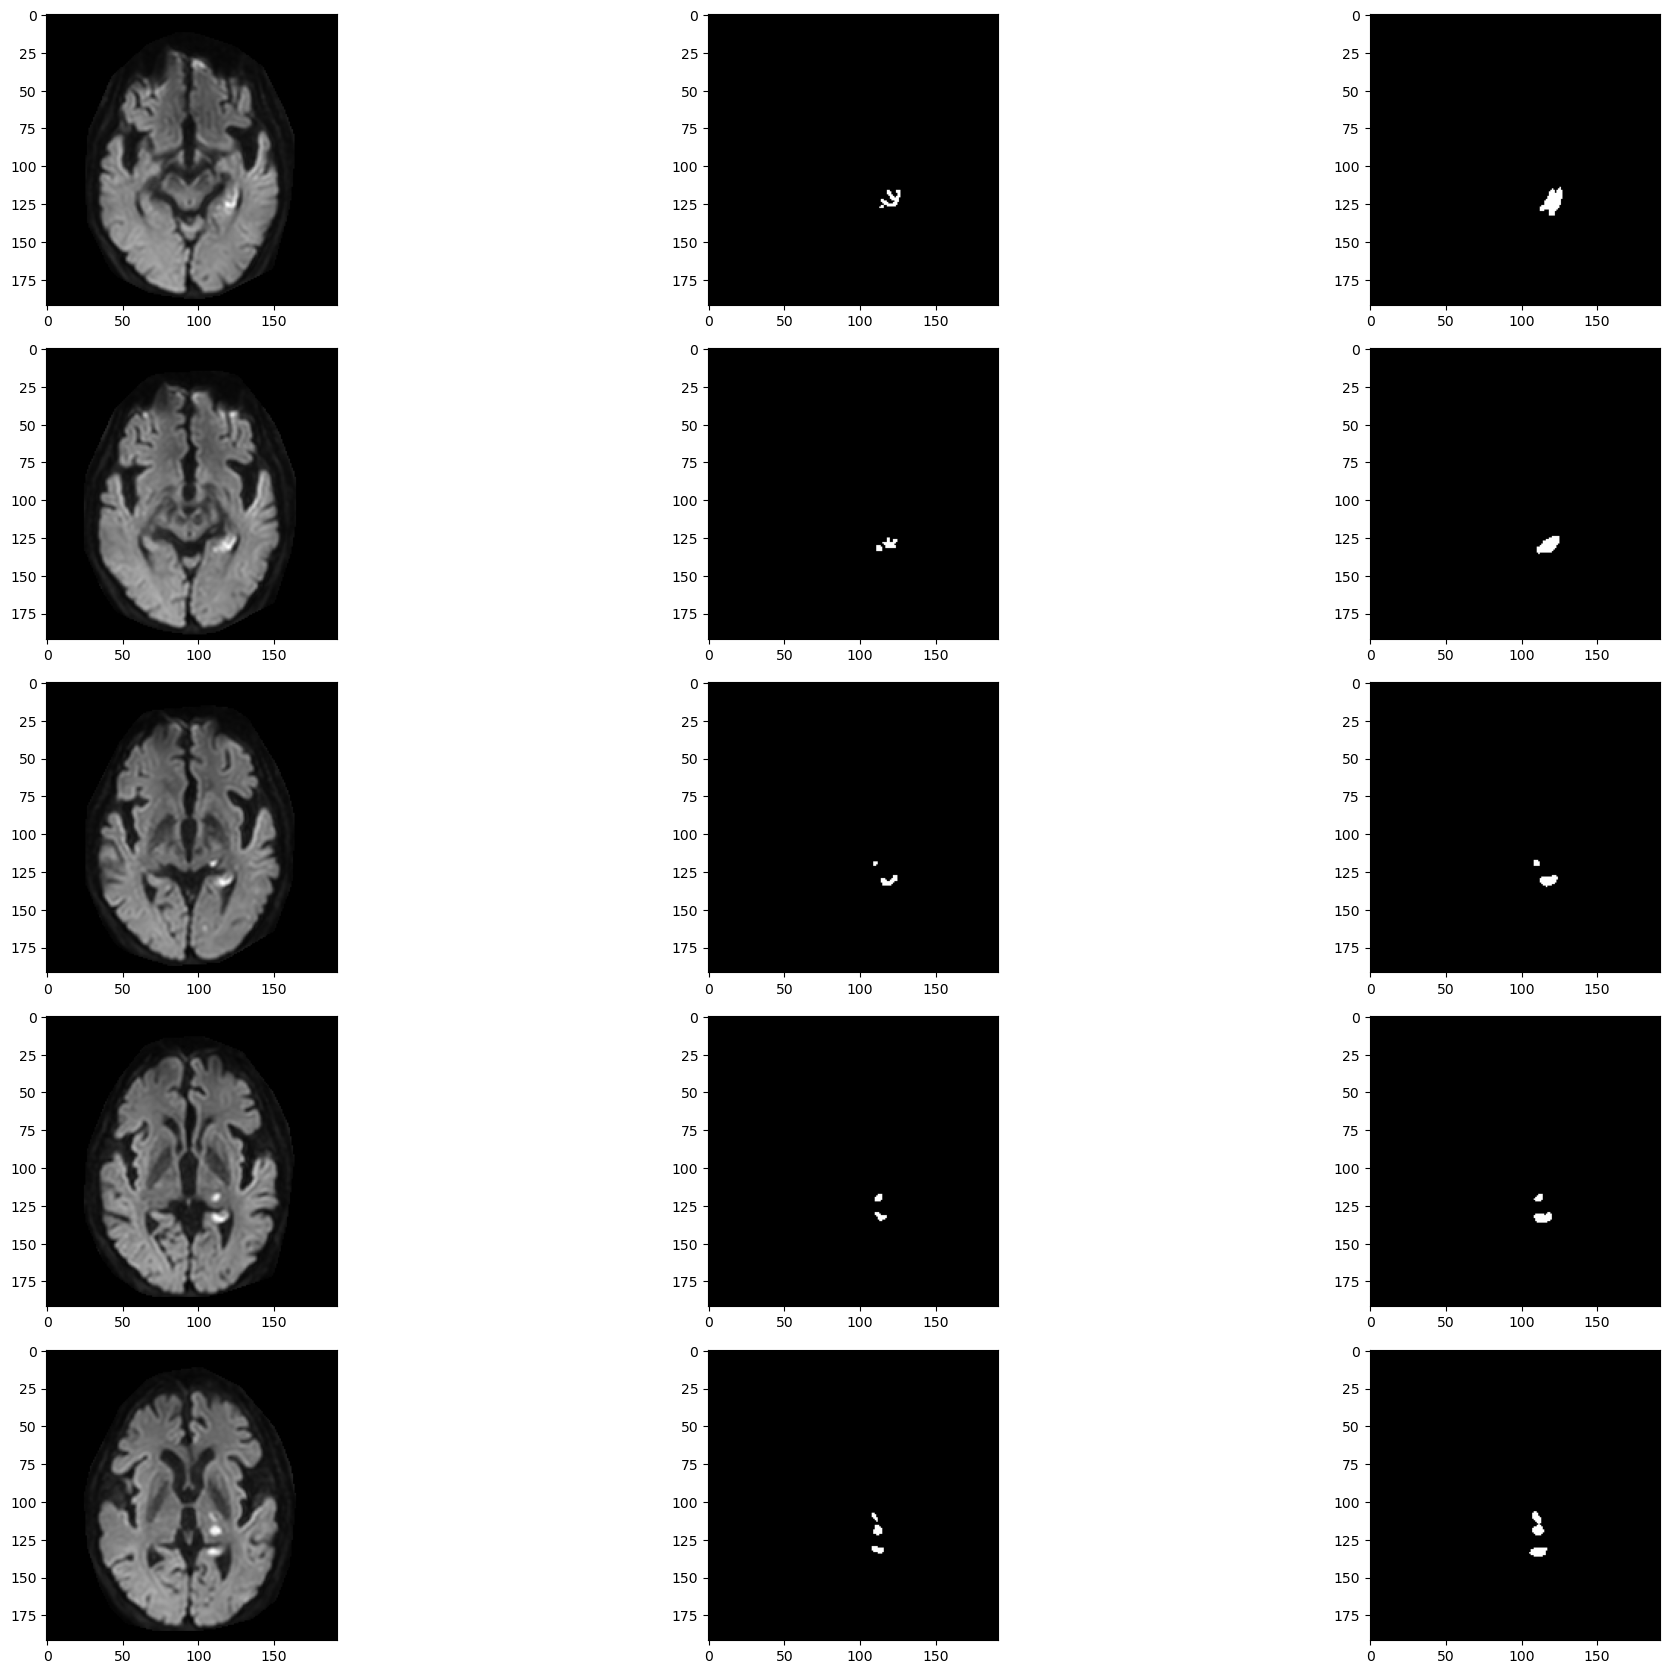

In [43]:
day=15
layer=20
fig = plt.figure(figsize=(20,50))
dwis = []
masks=[]
print(test_dataset[day].res_path)
path = test_dataset[day].res_path
print(path[:-13])
infer = np.load(test_dataset[day].res_path)
dwi = test_dataset[day].dwi[tio.DATA][0]
mask = test_dataset[day].mask[tio.DATA][0]
for i in range(5):
    # dwis.append(dwi[layer+i])
    # masks.append(mask[layer+i])
    fig.add_subplot(15,3,(i+1)*3-2).imshow(dwi[layer+i],cmap='gray')
    fig.add_subplot(15,3,(i+1)*3-1).imshow(mask[layer+i],cmap='gray')
    fig.add_subplot(15,3,(i+1)*3).imshow(infer[layer+i],cmap='gray')
plt.tight_layout()